## The impact of Covid-19 on the metro entries in New York City

In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sqlalchemy import create_engine, event

%matplotlib inline

### Data Collection

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
from tqdm import tqdm

def concant(weeks):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for i in tqdm(weeks):
        url_file = url.format(i)
        print(url_file)
        dfs.append(pd.read_csv(url_file))
    return pd.concat(dfs)
'''
def generate_dates(sdate):
    dates = pd.date_range(sdate, pd.to_datetime("today")-timedelta(days=1),freq='w-sat')
    weeks = [i.strftime('%y%m%d') for i in list(dates)]
    print(weeks)
    return concant(weeks)
'''
def generate_dates(sdate):
    dates = pd.date_range(sdate,pd.to_datetime("today")-timedelta(days=1),freq='w-sat')
    weeks = [i.strftime('%y%m%d') for i in list(dates)]
    return concant(weeks)

In [ ]:
df = generate_dates(pd.to_datetime('2015-01-01 00:00:00'))

In [3]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
210399,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/24/2021,21:00:00,5554,646,2021-09-24 21:00:00
210398,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/24/2021,17:00:00,5554,646,2021-09-24 17:00:00
210397,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/24/2021,13:00:00,5554,645,2021-09-24 13:00:00
210396,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/24/2021,09:00:00,5554,645,2021-09-24 09:00:00
210395,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/24/2021,05:00:00,5554,645,2021-09-24 05:00:00


### Data Cleaning

In [5]:
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [6]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'ENTRIES',
       'EXITS                                                               ',
       'DATE_TIME'],
      dtype='object')

In [7]:
df.columns = [column.strip() for column in df.columns]

In [8]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'ENTRIES', 'EXITS', 'DATE_TIME'],
      dtype='object')

In [ ]:
df.DATE.value_counts().sort_index()

In [11]:
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2015-12-26 03:00:00,1
47011376,R143,R032,02-03-01,TIMES SQ-42 ST,2017-11-14 03:00:00,1
47011362,R143,R032,02-03-01,TIMES SQ-42 ST,2017-11-11 19:00:00,1
47011363,R143,R032,02-03-01,TIMES SQ-42 ST,2017-11-11 23:00:00,1
47011364,R143,R032,02-03-01,TIMES SQ-42 ST,2017-11-12 03:00:00,1


In [12]:
turnstiles_daily = (df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [14]:
turnstiles_daily['DATE'] =  pd.to_datetime(turnstiles_daily['DATE'], format="%m/%d/%Y")
turnstiles_daily.sort_values(by='DATE', inplace=True)

In [15]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
11355830,R628,R064,00-00-00,SARATOGA AVE,2014-12-27,8164350
1132841,C001,R108,01-00-01,BOROUGH HALL/CT,2014-12-27,774182
11368963,R629,R065,00-00-01,ROCKAWAY AVE,2014-12-27,5329833
1484183,D008,R392,00-00-02,18 AVE,2014-12-27,6803260
4636648,N314,R238,01-06-00,STEINWAY ST,2014-12-27,9022628


In [83]:
turnstiles_daily.shape

(11684433, 9)

In [52]:
turnstiles_daily.to_csv('turnstile_daily.csv')

In [16]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

C:\Users\elaaf\AppData\Local\Temp/ipykernel_5432/4241375361.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [17]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
11355830,R628,R064,00-00-00,SARATOGA AVE,2014-12-27,8164350,NaT,NaN
1132841,C001,R108,01-00-01,BOROUGH HALL/CT,2014-12-27,774182,NaT,NaN
11368963,R629,R065,00-00-01,ROCKAWAY AVE,2014-12-27,5329833,NaT,NaN
1484183,D008,R392,00-00-02,18 AVE,2014-12-27,6803260,NaT,NaN
4636648,N314,R238,01-06-00,STEINWAY ST,2014-12-27,9022628,NaT,NaN


In [18]:
turnstiles_daily.tail()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
3944739,N141,R356,00-00-03,OZONE PK LEFFRT,2021-09-24,3978092,2021-09-23,3977596.0
1356011,C023,R213,00-00-00,BAY RIDGE AV,2021-09-24,3408268,2021-09-23,3407744.0
7065476,PTH18,R549,01-00-06,NEWARK BM BW,2021-09-24,118166,2021-09-23,117854.0
4443916,N304,R015,01-06-00,5 AV/53 ST,2021-09-24,5340482,2021-09-23,5340273.0
9423356,R256,R182,00-00-00,116 ST,2021-09-24,10400051,2021-09-23,10398354.0


In [19]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [20]:
how_many_stations_is_reversed = (turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

In [21]:
sum(how_many_stations_is_reversed)

99617

In [22]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [23]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
6948420,PTH13,R541,00-04-08,THIRTY ST,2014-12-28,1,2014-12-27,1.0,0.0
7905238,R154,R116,00-00-03,50 ST,2014-12-28,4412812,2014-12-27,4411972.0,840.0
4439845,N304,R015,01-03-00,5 AVE-53 ST,2014-12-28,10191788,2014-12-27,10191775.0,13.0
1306130,C018,R197,00-00-04,36 ST,2014-12-28,9248859,2014-12-27,9247927.0,932.0
1736444,H001,R175,00-00-00,8 AVE,2014-12-28,625624,2014-12-27,622875.0,2749.0


In [25]:
turnstiles_daily.dtypes

C/A                      object
UNIT                     object
SCP                      object
STATION                  object
DATE             datetime64[ns]
ENTRIES                   int64
PREV_DATE        datetime64[ns]
PREV_ENTRIES            float64
DAILY_ENTRIES           float64
dtype: object

In [26]:
turnstiles_daily.shape

(11684433, 9)

In [27]:
turnstile = turnstiles_daily.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
turnstile.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRIES
0,A002,R051,02-00-00,59 ST,2015-12-27,676.0
1,A002,R051,02-00-00,59 ST,2015-12-28,1601.0
2,A002,R051,02-00-00,59 ST,2015-12-29,1592.0
3,A002,R051,02-00-00,59 ST,2015-12-30,1758.0
4,A002,R051,02-00-00,59 ST,2015-12-31,1364.0


In [28]:
turnstile.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRIES
0,A002,R051,02-00-00,59 ST,2015-12-27,676.0
1,A002,R051,02-00-00,59 ST,2015-12-28,1601.0
2,A002,R051,02-00-00,59 ST,2015-12-29,1592.0
3,A002,R051,02-00-00,59 ST,2015-12-30,1758.0
4,A002,R051,02-00-00,59 ST,2015-12-31,1364.0


In [29]:
turnstile['DATE'] =  pd.to_datetime(turnstile['DATE'], format="%m/%d/%Y")
turnstile.sort_values(by='DATE', inplace=True)

In [30]:
turnstile.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRIES
7422439,R113,R028,01-04-00,FULTON ST,2014-12-28,249.0
10055135,R402,R446,00-00-00,BROOK AVE,2014-12-28,955.0
789968,B010,R412,00-00-00,BOTANIC GARDEN,2014-12-28,383.0
11503354,R645,R110,00-05-00,FLATBUSH AVE,2014-12-28,1.0
8346048,R186,R036,00-00-00,DYCKMAN ST,2014-12-28,1174.0


In [37]:
turnstile.tail()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRIES
4203785,N208,R443,01-00-00,170 ST,2021-09-24,280.0
10702499,R526,R096,00-05-02,82 ST-JACKSON H,2021-09-24,815.0
4201324,N207,R104,00-00-03,167 ST,2021-09-24,1019.0
3937703,N141,R356,00-00-01,OZONE PK LEFFRT,2021-09-24,451.0
11684432,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-09-24,0.0


In [32]:
turnstile.shape

(11684433, 6)

### Prepare Data for visulaization in tabluea

In [58]:
id_date_daily_entries = pd.DataFrame({})

In [59]:
id_date_daily_entries['ID'] = turnstiles_daily["C/A"] +  turnstiles_daily["UNIT"]+ turnstiles_daily["SCP"] +turnstiles_daily["STATION"]

In [60]:
id_date_daily_entries['DATE'] = turnstiles_daily['DATE']
id_date_daily_entries['DAILY_ENTRIES'] = turnstiles_daily['DAILY_ENTRIES']

In [63]:
id_date_daily_entries.head()
id_date_daily_entries.to_csv('turnstile_id.csv')

In [84]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
6948420,PTH13,R541,00-04-08,THIRTY ST,2014-12-28,1,2014-12-27,1.0,0.0
7905238,R154,R116,00-00-03,50 ST,2014-12-28,4412812,2014-12-27,4411972.0,840.0
4439845,N304,R015,01-03-00,5 AVE-53 ST,2014-12-28,10191788,2014-12-27,10191775.0,13.0
1306130,C018,R197,00-00-04,36 ST,2014-12-28,9248859,2014-12-27,9247927.0,932.0
1736444,H001,R175,00-00-00,8 AVE,2014-12-28,625624,2014-12-27,622875.0,2749.0


### Data Visualization

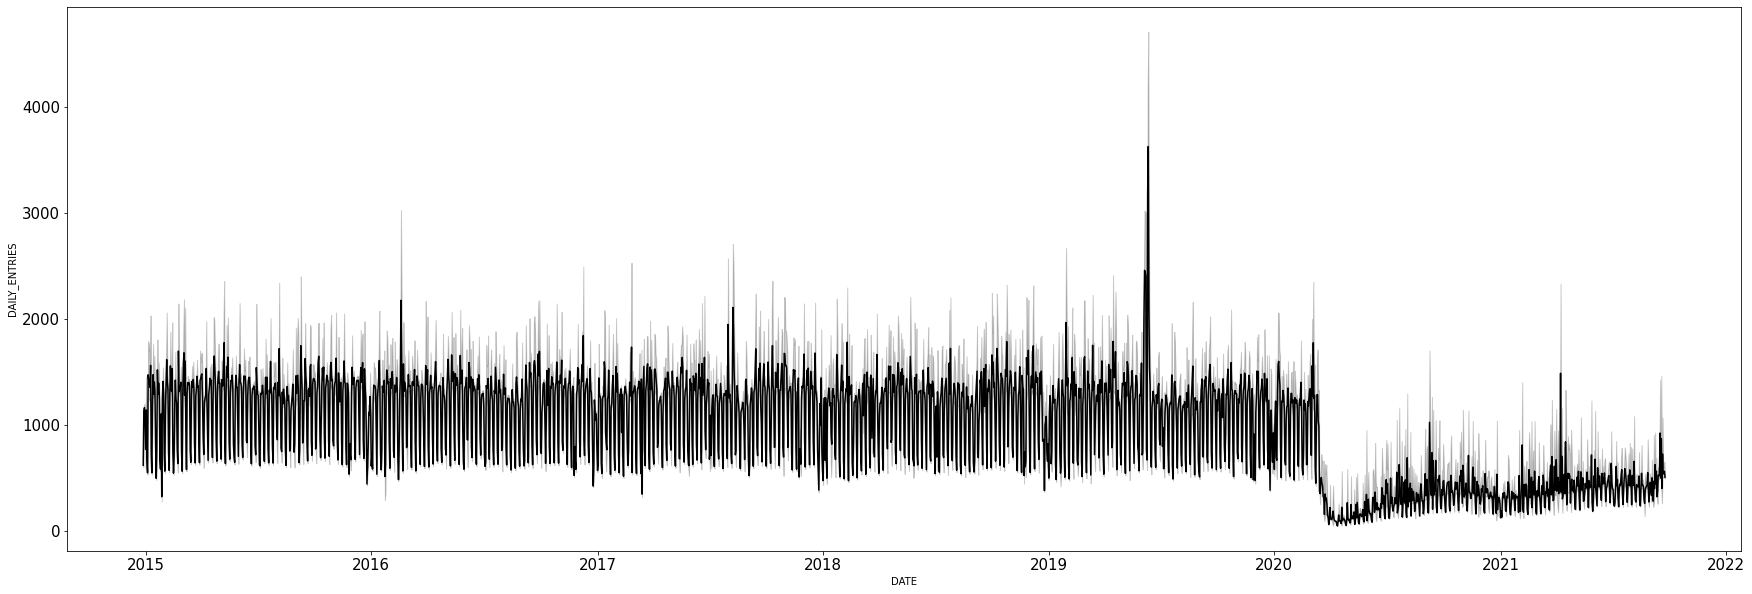

In [86]:
fig, ax = plt.subplots(figsize=(30,10))
sns.lineplot( x= turnstile.DATE,y=turnstile.DAILY_ENTRIES, color='black')
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.show()

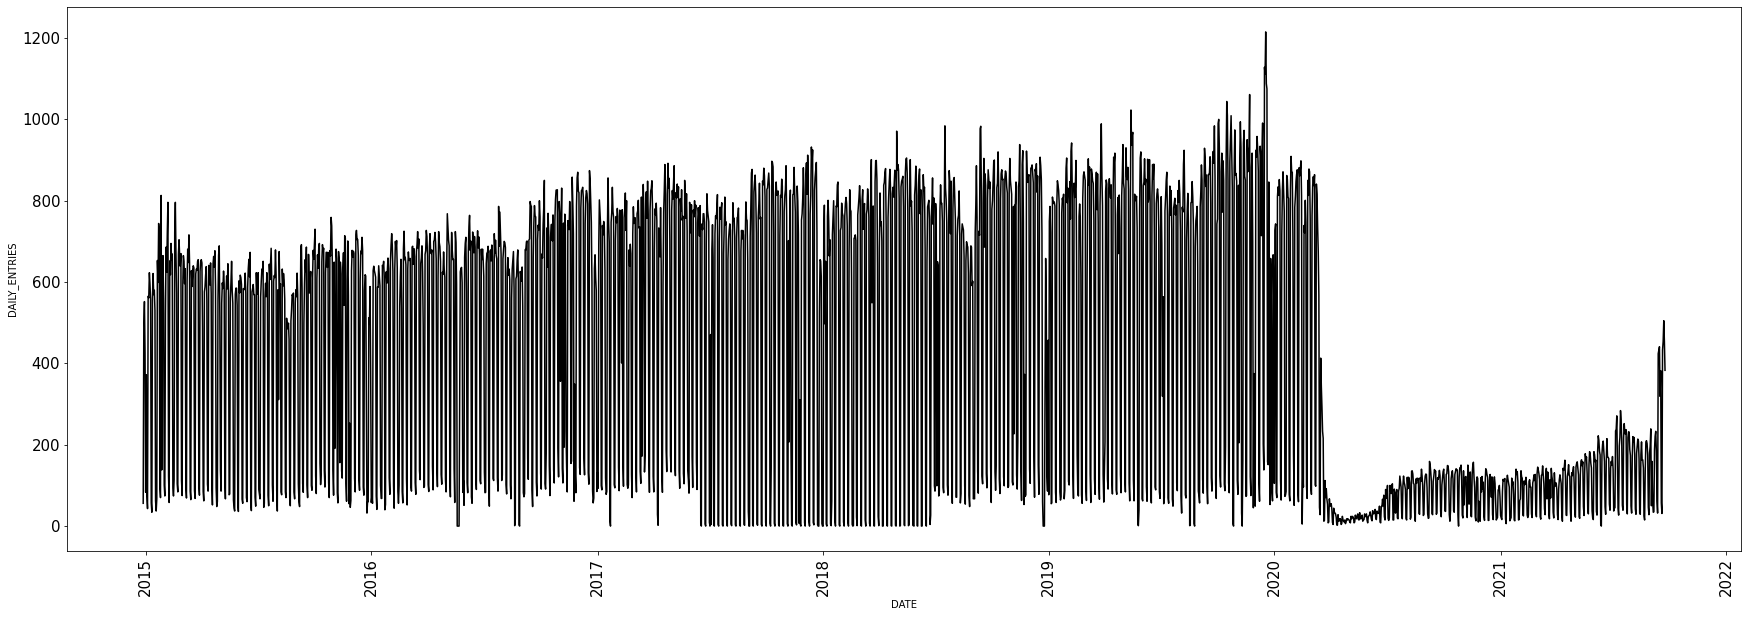

In [90]:
mask = ((turnstile["C/A"] == "R114") & 
(turnstile["UNIT"] == "R028") & 
(turnstile["SCP"] == "02-00-03") & 
(turnstile["STATION"] == "FULTON ST"))

test = turnstile[mask]

fig, ax = plt.subplots(figsize=(30,10))
sns.lineplot( x= test.DATE,y=test.DAILY_ENTRIES, color='black')
plt.xticks(rotation = 'vertical')
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.show()

In [ ]:
test.head()

In [ ]:
test.shape

In [ ]:
fig, ax = plt.subplots(figsize=(100,10))
sns.lineplot( x= test.DATE[50:],y=test.DAILY_ENTRIES[50:])
plt.xticks(rotation = 'vertical')
plt.show()

In [ ]:
total_ridership_values = turnstiles_daily.groupby(['STATION'])[["DAILY_ENTRIES"]].sum().sort_values('DAILY_ENTRIES', ascending=False).reset_index()
total_ridership_values.head()

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,319814177.0
1,34 ST-HERALD SQ,227536092.0
2,GRD CNTRL-42 ST,216415841.0
3,23 ST,197421403.0
4,14 ST-UNION SQ,195099245.0


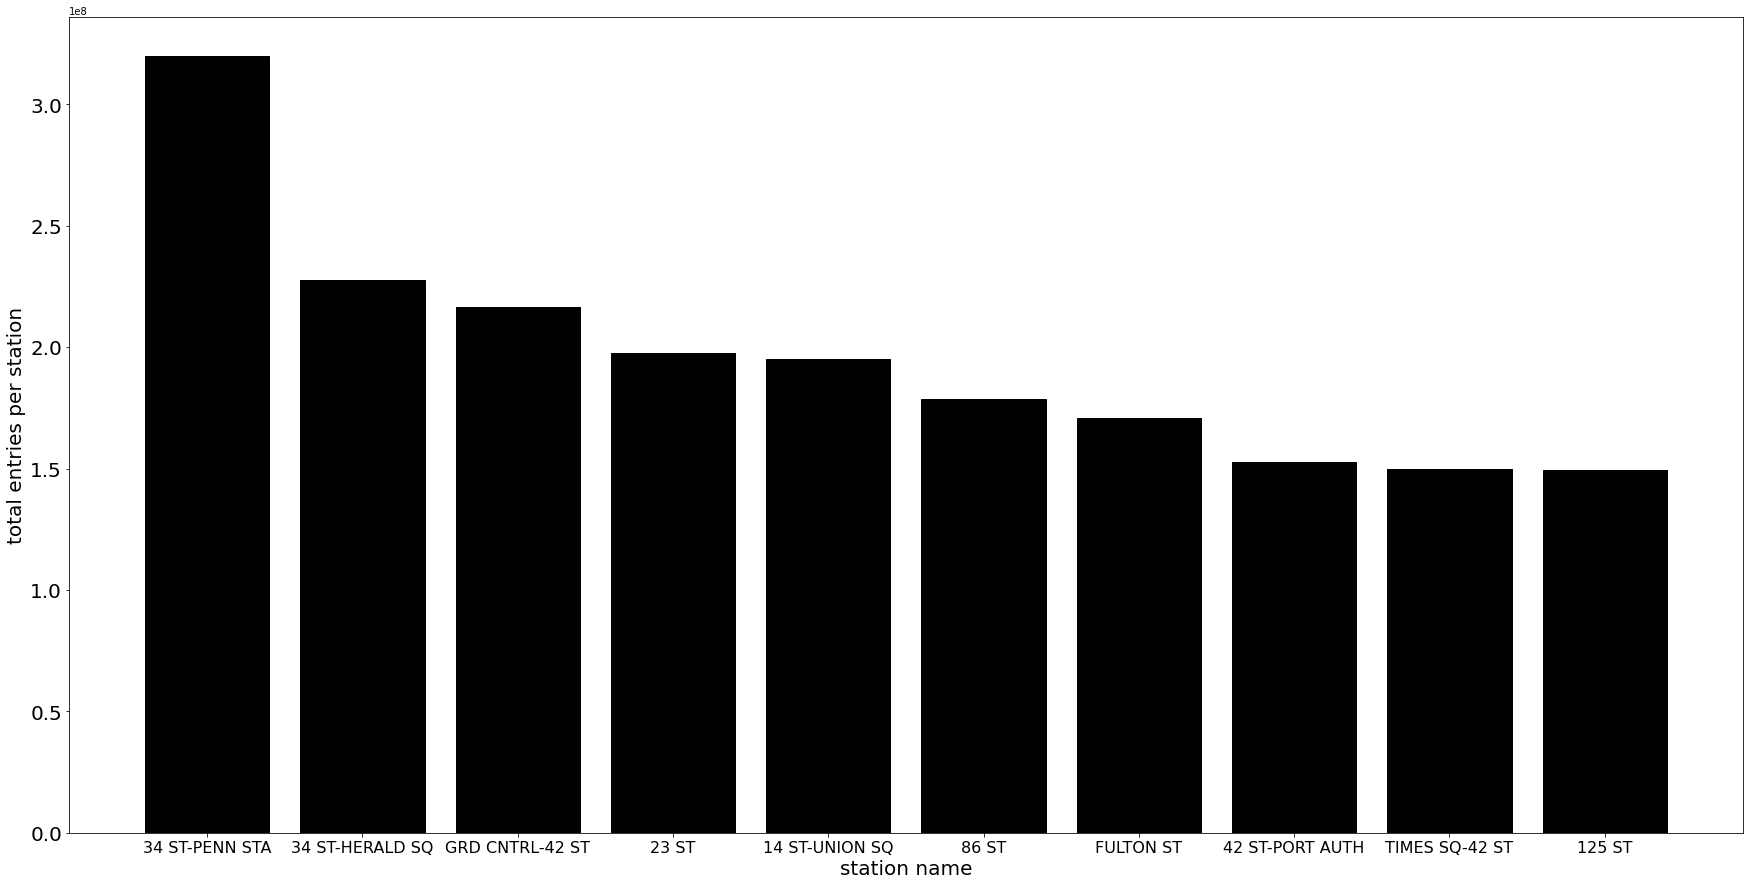

In [91]:
plt.figure(figsize=(30,15));
plt.xlabel("station name", size=20)
plt.ylabel("total entries per station", size =20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.bar(total_ridership_values['STATION'][:10], 
        total_ridership_values['DAILY_ENTRIES'][:10],edgecolor='black', linewidth=1, color='black');

### Using SQLAlchemey to access data

In [75]:
engine = create_engine('sqlite:///turnstile.db') 

In [76]:
connection = engine.connect()

In [79]:
result = engine.execute('select * from MTA')

In [80]:
count = 0
for row in result:
    print(row)
    count +=1
    
    if count > 10:
        break

(7422439, 'R113', 'R028', '01-04-00', 'FULTON ST', '2014-12-28 00:00:00.000000', 249.0)
(10055135, 'R402', 'R446', '00-00-00', 'BROOK AVE', '2014-12-28 00:00:00.000000', 955.0)
(789968, 'B010', 'R412', '00-00-00', 'BOTANIC GARDEN', '2014-12-28 00:00:00.000000', 383.0)
(11503354, 'R645', 'R110', '00-05-00', 'FLATBUSH AVE', '2014-12-28 00:00:00.000000', 1.0)
(8346048, 'R186', 'R036', '00-00-00', 'DYCKMAN ST', '2014-12-28 00:00:00.000000', 1174.0)
(1823025, 'H009', 'R235', '00-00-00', 'BEDFORD AVE', '2014-12-28 00:00:00.000000', 2350.0)
(765346, 'A085', 'R125', '02-05-00', 'BROAD ST', '2014-12-28 00:00:00.000000', 0.0)
(4348368, 'N223', 'R156', '01-06-01', 'BEDFORD PARK BL', '2014-12-28 00:00:00.000000', 415.0)
(11635144, 'S101A', 'R070', '01-03-02', 'ST. GEORGE', '2014-12-28 00:00:00.000000', 133.0)
(6766455, 'PTH07', 'R550', '00-00-00', 'CITY / BUS', '2014-12-28 00:00:00.000000', 146.0)
(10415014, 'R508', 'R346', '00-00-01', 'COURT SQ', '2014-12-28 00:00:00.000000', 315.0)
